<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
Aggrgeation of NOAA VIIRS I-Bands Fire Pixel and DCOMP Products
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

In [8]:
from calendar import monthrange

import netCDF4
import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import random
import re
import warnings

warnings.filterwarnings('ignore')

In [9]:
root = '/Volumes/HD2/Datasets/Research'

In [10]:
year = 2023
month = 2
day = 20

In [11]:
platform = 'SNPP'
product = 'SNPP_VIIRS_AF_I-Band_EDR_NRT'

AF_IBand_Files = glob.glob('{}/NOAA_AWS/{}/VIIRS/{}/{:04d}/{:04d}_{:02d}_{:02d}/*.nc'.format(root,platform,product,year,year,month,day))

print( len(AF_IBand_Files) )

1013


In [12]:
platform = 'SNPP'
product = 'SNPP_VIIRS_Cloud_Mask_EDR'

Cloud_Mask_Files = glob.glob('{}/NOAA_AWS/{}/VIIRS/{}/{:04d}/{:04d}_{:02d}_{:02d}/*.nc'.format(root,platform,product,year,year,month,day))

print( len(Cloud_Mask_Files) )

1003


In [13]:
platform = 'SNPP'
product = 'SNPP_VIIRS_Daytime_Cloud_Optical_and_Microphysical_Properties_DCOMP_EDR'

DCOMP_Files = glob.glob('{}/NOAA_AWS/{}/VIIRS/{}/{:04d}/{:04d}_{:02d}_{:02d}/*.nc'.format(root,platform,product,year,year,month,day))

print( len(DCOMP_Files) )

542


In [14]:
%%time

df = pd.DataFrame()

for idx,AF_IBand_File in enumerate(AF_IBand_Files):
    
    if idx % 100 == 0: print(idx)
    
    filename = AF_IBand_File.split('/')[-1]
    
    m = re.search('AF-Iband_v1r1_npp_s(.*)_e(.*)_c(.*).nc', filename)
    
    date = m.group(1)[0:8]
    time = m.group(1)[8:15]
    
    timestamp = '{}{}'.format(date,time)
    
    Cloud_Mask_File = ''
    
    Cloud_Mask_File_List = [f for f in Cloud_Mask_Files if timestamp in f]
    
    DCOMP_File = ''
    
    DCOMP_File_List = [f for f in DCOMP_Files if timestamp in f]
    
    find_match_file = True
    if not len(Cloud_Mask_File_List) > 0: find_match_file = False
    if not len(DCOMP_File_List) > 0: find_match_file = False
    
    if find_match_file:
        
        Cloud_Mask_File = Cloud_Mask_File_List[0]
        DCOMP_File = DCOMP_File_List[0]

        df_new = pd.DataFrame()

        #print(granule_year,granule_month,granule_day)

        f = netCDF4.Dataset(AF_IBand_File)
        
        fmg = f.groups['Fire Mask']
        
        fire_mask_v = fmg.variables['fire_mask']
        
        data =  ma.getdata(fire_mask_v)
        
        #print(data.shape)
        
        fpg = f.groups['Fire Pixels']

        for name in ['FP_line',
 'FP_sample',
 'FP_latitude',
 'FP_longitude',
 'FP_T4',
 'FP_T5',
 'FP_MeanT4',
 'FP_MeanT5',
 'FP_MeanDT',
 'FP_MAD_T4',
 'FP_MAD_T5',
 'FP_MAD_DT',
 'FP_power',
 'FP_Rad13',
 'FP_MeanRad13',
 'FP_AdjCloud',
 'FP_AdjWater',
 'FP_WinSize',
 'FP_confidence',
 'FP_day',
 'FP_SolZenAng',
 'FP_SolAzAng',
 'FP_ViewZenAng',
 'FP_ViewAzAng',
 'FP_PersistentAnomalyCategory']:

            data_obj = fpg.variables[name]

            data =  ma.getdata(data_obj)
            
            #print(data.shape)

            df_new[name] = data.ravel()   

        df_new['Day_Night_Flag'] = f.day_night_data_flag  

        f.close()
        
        if not df_new.empty:
            
            dfg = pd.DataFrame()
        
            f = netCDF4.Dataset(Cloud_Mask_File)
                        
            data = f.variables['CloudMask']

            data = ma.getdata(data)
            
            data = np.kron(data, np.ones((2,2)))
            
            #print('YES')
            #print(data.shape)
            
            x_axis_size = data.shape[1]
            y_axis_size = data.shape[0] 

            xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))

            dfg['FP_sample'] = xv.flatten() 
            dfg['FP_line'] = yv.flatten() 

            dfg['Cloud_Mask'] = data.ravel()
            
            dfg['Cloud_Mask_FileName'] = Cloud_Mask_File.split('/')[-1]
            
            f.close()
            
            f = netCDF4.Dataset(DCOMP_File)
                        
            data = f.variables['CloudMicroVisOD']

            data = ma.getdata(data)
            
            data = np.kron(data, np.ones((2,2)))
            
            dfg['CloudMicroVisOD'] = data.ravel()
            
            dfg['CloudMicroVisOD_FileName'] = DCOMP_File.split('/')[-1]
            
            f.close()   
            
            df_new = pd.merge(df_new,dfg,on=['FP_sample','FP_line'],how='inner',indicator=False)
            
            df = pd.concat([df,df_new], axis=0)  

0
100
200
300
400
500
600
700
800
900
1000
CPU times: user 4min 32s, sys: 33.4 s, total: 5min 6s
Wall time: 5min 37s


In [15]:
df

,FP_line,FP_sample,FP_latitude,FP_longitude,FP_T4,FP_T5,FP_MeanT4,FP_MeanT5,FP_MeanDT,FP_MAD_T4,...,FP_SolZenAng,FP_SolAzAng,FP_ViewZenAng,FP_ViewAzAng,FP_PersistentAnomalyCategory,Day_Night_Flag,Cloud_Mask,Cloud_Mask_FileName,CloudMicroVisOD,CloudMicroVisOD_FileName
0,820,5363,-44.794647,170.922836,367.000000,300.589691,0.000000,0.000000,0.000000,0.000000,...,35.919895,-24.560261,55.907143,86.709770,0,Day,0.0,JRR-CloudMask_v2r3_npp_s202302200146508_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302200146508_e2023...
1,820,5364,-44.794842,170.918182,345.076752,295.693237,301.032440,291.756104,9.276193,1.607823,...,35.918701,-24.552717,55.919388,86.713005,0,Day,0.0,JRR-CloudMask_v2r3_npp_s202302200146508_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302200146508_e2023...
2,876,5307,-44.619152,171.154449,347.136841,293.604767,301.329163,292.416870,8.912321,2.659002,...,35.834091,-25.055243,55.219101,86.226547,0,Day,0.0,JRR-CloudMask_v2r3_npp_s202302200146508_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302200146508_e2023...
3,904,5317,-44.539371,171.095093,367.000000,296.732178,0.000000,0.000000,0.000000,0.000000,...,35.746159,-25.019123,55.342567,86.105621,0,Day,0.0,JRR-CloudMask_v2r3_npp_s202302200146508_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302200146508_e2023...
4,904,5318,-44.539585,171.090576,355.690186,295.798523,304.658051,294.196075,10.462007,2.810108,...,35.744987,-25.011770,55.354713,86.108833,0,Day,0.0,JRR-CloudMask_v2r3_npp_s202302200146508_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302200146508_e2023...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,1135,4977,15.580215,45.800556,300.033997,278.680237,275.431335,276.734863,-1.303563,0.876409,...,151.989548,83.576004,49.489223,-78.735611,1,Night,1.0,JRR-CloudMask_v2r3_npp_s202302202302510_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302202224268_e2023...
15,1135,4978,15.579204,45.805779,298.422791,279.171631,275.368103,276.734650,-1.366538,0.807547,...,151.984665,83.580345,49.512192,-78.734222,1,Night,1.0,JRR-CloudMask_v2r3_npp_s202302202302510_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302202224268_e2023...
16,1135,5201,15.376923,46.838009,314.054199,282.176208,277.740021,280.085541,-2.345379,1.674145,...,151.016418,84.417908,53.781536,-78.462082,1,Night,1.0,JRR-CloudMask_v2r3_npp_s202302202302510_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302202224268_e2023...
17,1142,5199,15.342806,46.824272,329.307037,285.335205,0.000000,0.000000,0.000000,0.000000,...,151.032913,84.473274,53.757595,-78.216919,1,Night,1.0,JRR-CloudMask_v2r3_npp_s202302202302510_e20230...,0.0,JRR-CloudDCOMP_v2r3_npp_s202302202224268_e2023...


In [16]:
df.columns

Index(['FP_line', 'FP_sample', 'FP_latitude', 'FP_longitude', 'FP_T4', 'FP_T5',
       'FP_MeanT4', 'FP_MeanT5', 'FP_MeanDT', 'FP_MAD_T4', 'FP_MAD_T5',
       'FP_MAD_DT', 'FP_power', 'FP_Rad13', 'FP_MeanRad13', 'FP_AdjCloud',
       'FP_AdjWater', 'FP_WinSize', 'FP_confidence', 'FP_day', 'FP_SolZenAng',
       'FP_SolAzAng', 'FP_ViewZenAng', 'FP_ViewAzAng',
       'FP_PersistentAnomalyCategory', 'Day_Night_Flag', 'Cloud_Mask',
       'Cloud_Mask_FileName', 'CloudMicroVisOD', 'CloudMicroVisOD_FileName'],
      dtype='object')

In [17]:
df['Cloud_Mask'].value_counts()

0.0    30936
3.0     7450
1.0     4530
2.0     4473
Name: Cloud_Mask, dtype: int64

In [18]:
df[ (df['Day_Night_Flag'] == 'Day') ]['Cloud_Mask'].count()

47366

In [19]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['Cloud_Mask'].count()

11913

In [20]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2 ) ]['Cloud_Mask'].count()

35453

In [21]:
df[ (df['Day_Night_Flag'] == 'Night') & 
    (df['Cloud_Mask'] > 1) ]['Cloud_Mask'].count()

6

In [22]:
df[ (df['Day_Night_Flag'] == 'Night') & 
    (df['Cloud_Mask'] < 2 ) ]['Cloud_Mask'].count()

13

In [23]:
df[ df['Day_Night_Flag'] == 'Day' ]['FP_power'].mean()

10.319049835205078

In [24]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].mean()

9.88177490234375

In [25]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].mean()

11.620408058166504

In [130]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].mode()[0]

2.1679838

In [131]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].mode()[0]

2.9360166

In [145]:
data_tmp = df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].to_numpy()

bins = [i for i in range(150)]

hx, hy =  np.histogram(data_tmp, bins=bins )

print(hx)
print(hy)

bin_max = np.where(hx == hx.max())[0]

print(bin_max)

print( hx[bin_max] )
print( ( hy[bin_max] + hy[bin_max+1] ) / 2.0 )

[  96 1618 4040 4839 4390 3651 2772 2234 1656 1321 1081  871  692  611
  510  451  337  312  321  273  259  186  193  173  144  136  146  112
  108   99   90   94   83   83   59   63   55   46   47   57   46   36
   30   41   47   23   39   21   26   25   46   24   24   21   28   27
   19   13   13   33   17   12   15   26   20   17    9   10    7    5
   13    5   16    8    7   18   13   14   11   11    5    8   11   11
    6    8    6   11   13    8    2   15    8    1    2    1    5    2
    1    7    0    0    3    5    0    1    2    3   10    2    3    1
    7    0    3    4    0    0    5    1    1    0    6    5    1    3
    4    4    0    1    0    3   10    1    0    1    2    7    2    2
    2    0    4    4    1    0    0    0    0]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59

In [134]:


data_tmp = df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].to_numpy()

bins = [i for i in range(150)]

hx, hy =  np.histogram(data_tmp, bins=bins )

print(hx)
print(hy)

bin_max = np.where(hx == hx.max())[0]

print(bin_max)

print( hx[bin_max] )
print( ( hy[bin_max] + hy[bin_max+1] ) / 2.0 )

[  26  462 1214 1450 1330 1153  849  765  592  461  346  363  290  238
  227  162  154  137  113   85  107  100   73   76   66   64   55   45
   48   47   38   43   33   31   43   33   36   44   31   23   26   19
   17   31    8   11   13   21    9    7   16   13    3    2    2    6
    1    8    7    2    4    4    5    2    3    9    7    5    8    1
   10    5    6    2    4    1    2    2    3    0    0    0    7    0
    2    4    0    1    1    0    4    4   13    3    3    0    7    4
    0    0    2    1    1    1    4    2    0    4    1    7    1    1
    0    0    2    2    4    1    1    1    0    1    0    0    0    3
    3    2    3    4    3    0    0    0    0    1    1    0    0    0
    2    0    0    1    2    0    4    0    3]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59

In [26]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].median()

6.360832691192627

<AxesSubplot:>

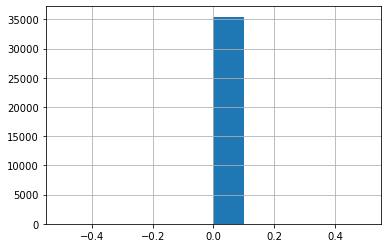

In [27]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['CloudMicroVisOD'].hist()

In [28]:
df[ df['CloudMicroVisOD'] > 0.0  ]['Cloud_Mask'].value_counts()

3.0    6733
2.0    3664
1.0       5
Name: Cloud_Mask, dtype: int64

<AxesSubplot:>

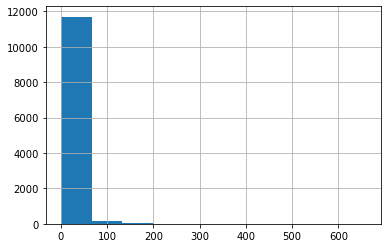

In [29]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].hist()

In [30]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].mean()

9.88177490234375

<AxesSubplot:>

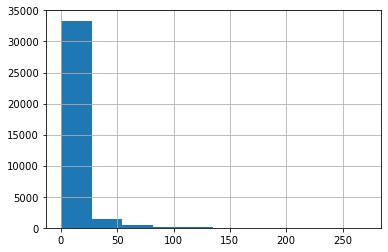

In [56]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].hist()

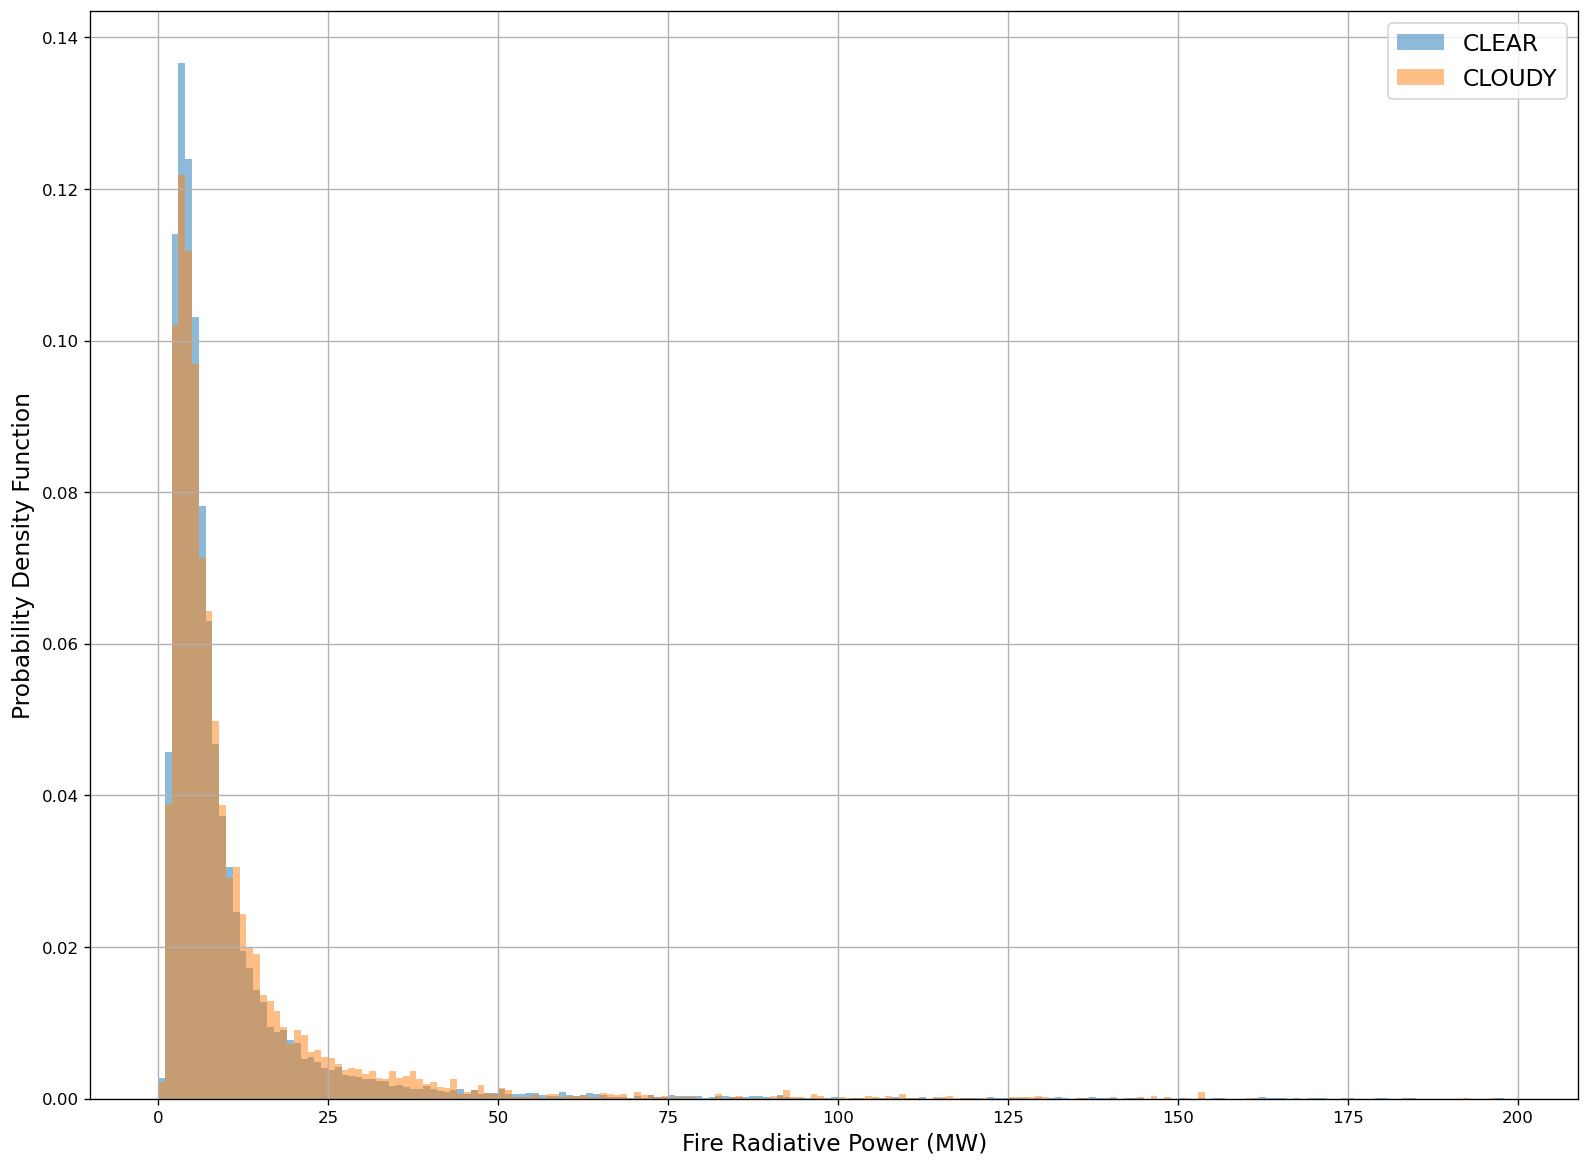

In [171]:
fig = plt.figure(num=None, figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')

bins = [i for i in range(200)]

df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].hist(bins=bins,density=True,alpha=0.5,label='CLEAR')

df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].hist(bins=bins,density=True,alpha=0.5,label='CLOUDY')

plt.ylabel("Probability Density Function",fontsize=14)
plt.xlabel("Fire Radiative Power (MW)",fontsize=14)

plt.legend(loc='upper right',fontsize=14)

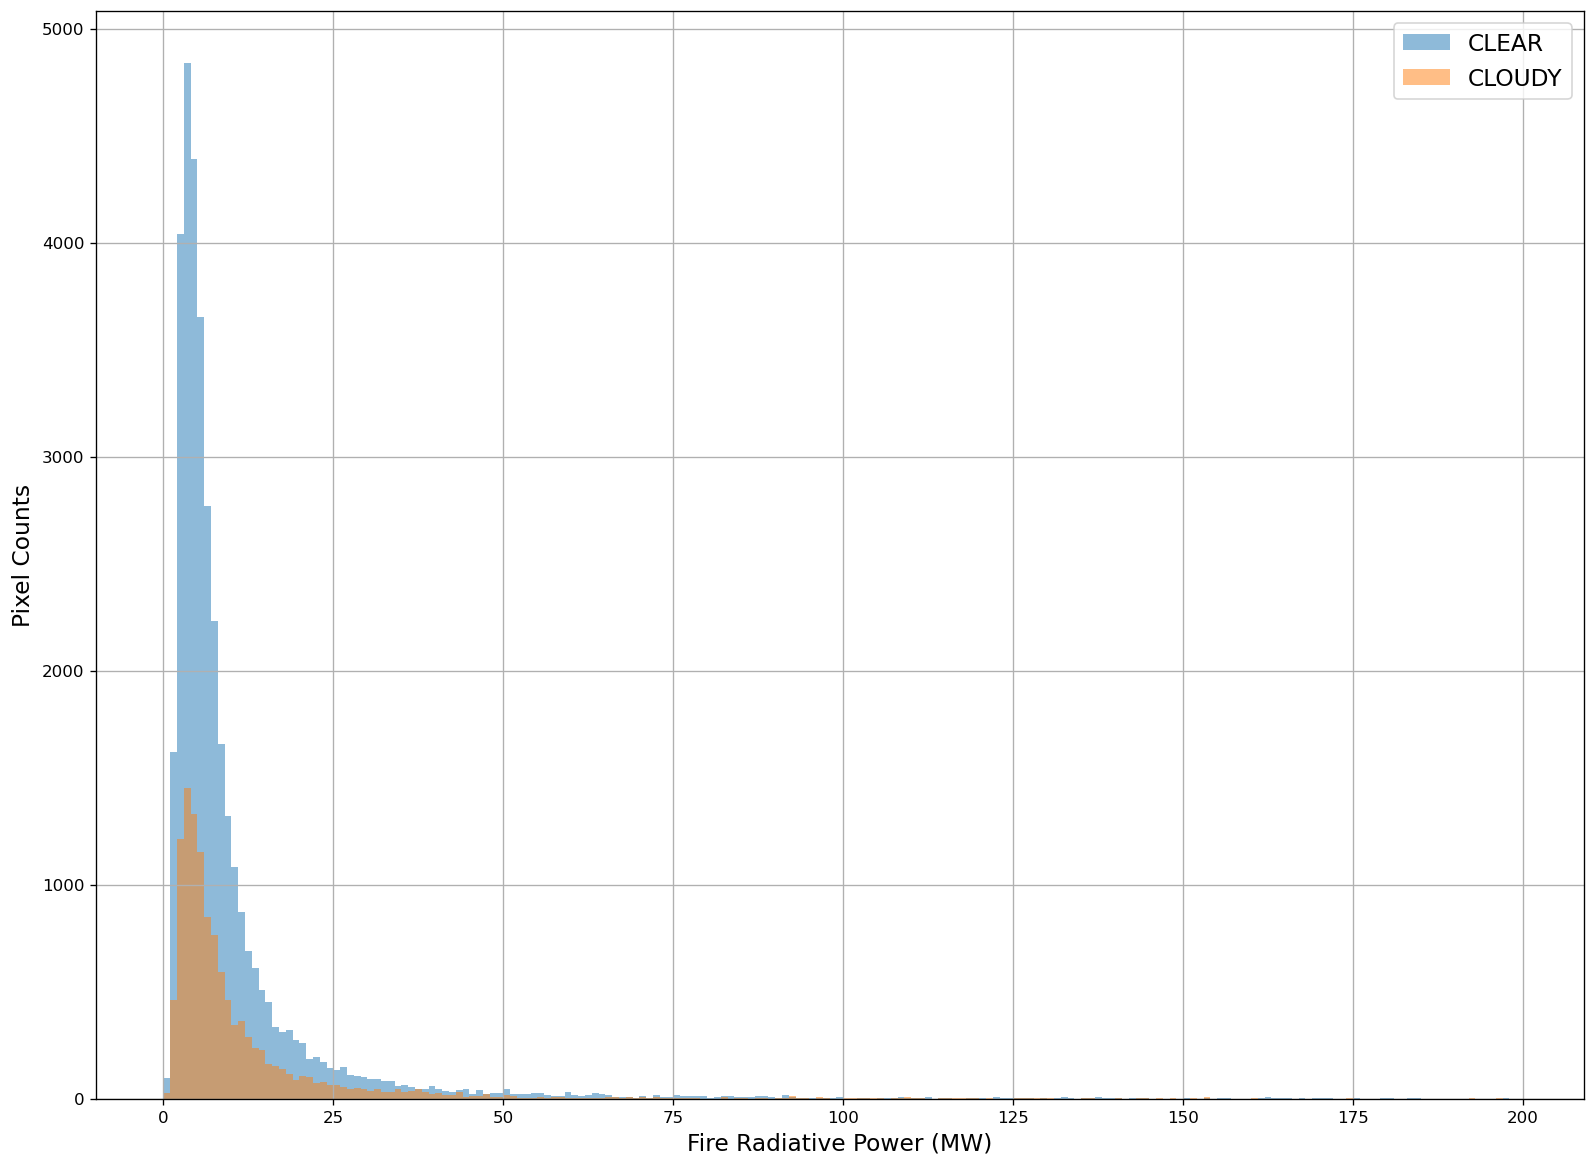

In [155]:
fig = plt.figure(num=None, figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')

bins = [i for i in range(200)]

df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] < 2) ]['FP_power'].hist(bins=bins,density=False,alpha=0.5,label='CLEAR')

df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].hist(bins=bins,density=False,alpha=0.5,label='CLOUDY')

plt.ylabel("Pixel Counts",fontsize=14)
plt.xlabel("Fire Radiative Power (MW)",fontsize=14)

plt.legend(loc='upper right',fontsize=14)

<Figure size 1920x1440 with 0 Axes>

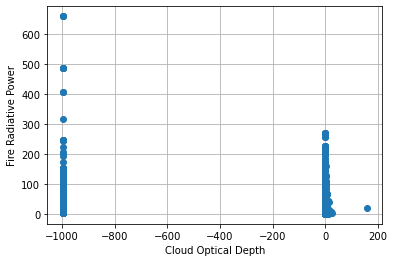

In [33]:
fig = plt.figure(num=None, figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')

ax = df.plot(x='CloudMicroVisOD', y='FP_power', style='o', legend=False)

ax.set_xlabel("Cloud Optical Depth")
ax.set_ylabel("Fire Radiative Power")

ax.set_title("")

#ax.set_xlim(0,10)
#ax.set_ylim(0,20)

ax.grid()

plt.show()

<Figure size 1920x1440 with 0 Axes>

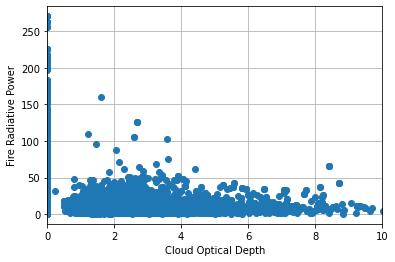

In [59]:
df_sub = df[  (df['CloudMicroVisOD'] >= 0.0) & (df['FP_power'] >= 0.0)      ]

fig = plt.figure(num=None, figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')

ax = df_sub.plot(x='CloudMicroVisOD', y='FP_power', style='o', legend=False)

ax.set_xlabel("Cloud Optical Depth")
ax.set_ylabel("Fire Radiative Power")

ax.set_title("")

ax.set_xlim(0,10)
#ax.set_ylim(0,20)

ax.grid()

plt.show()

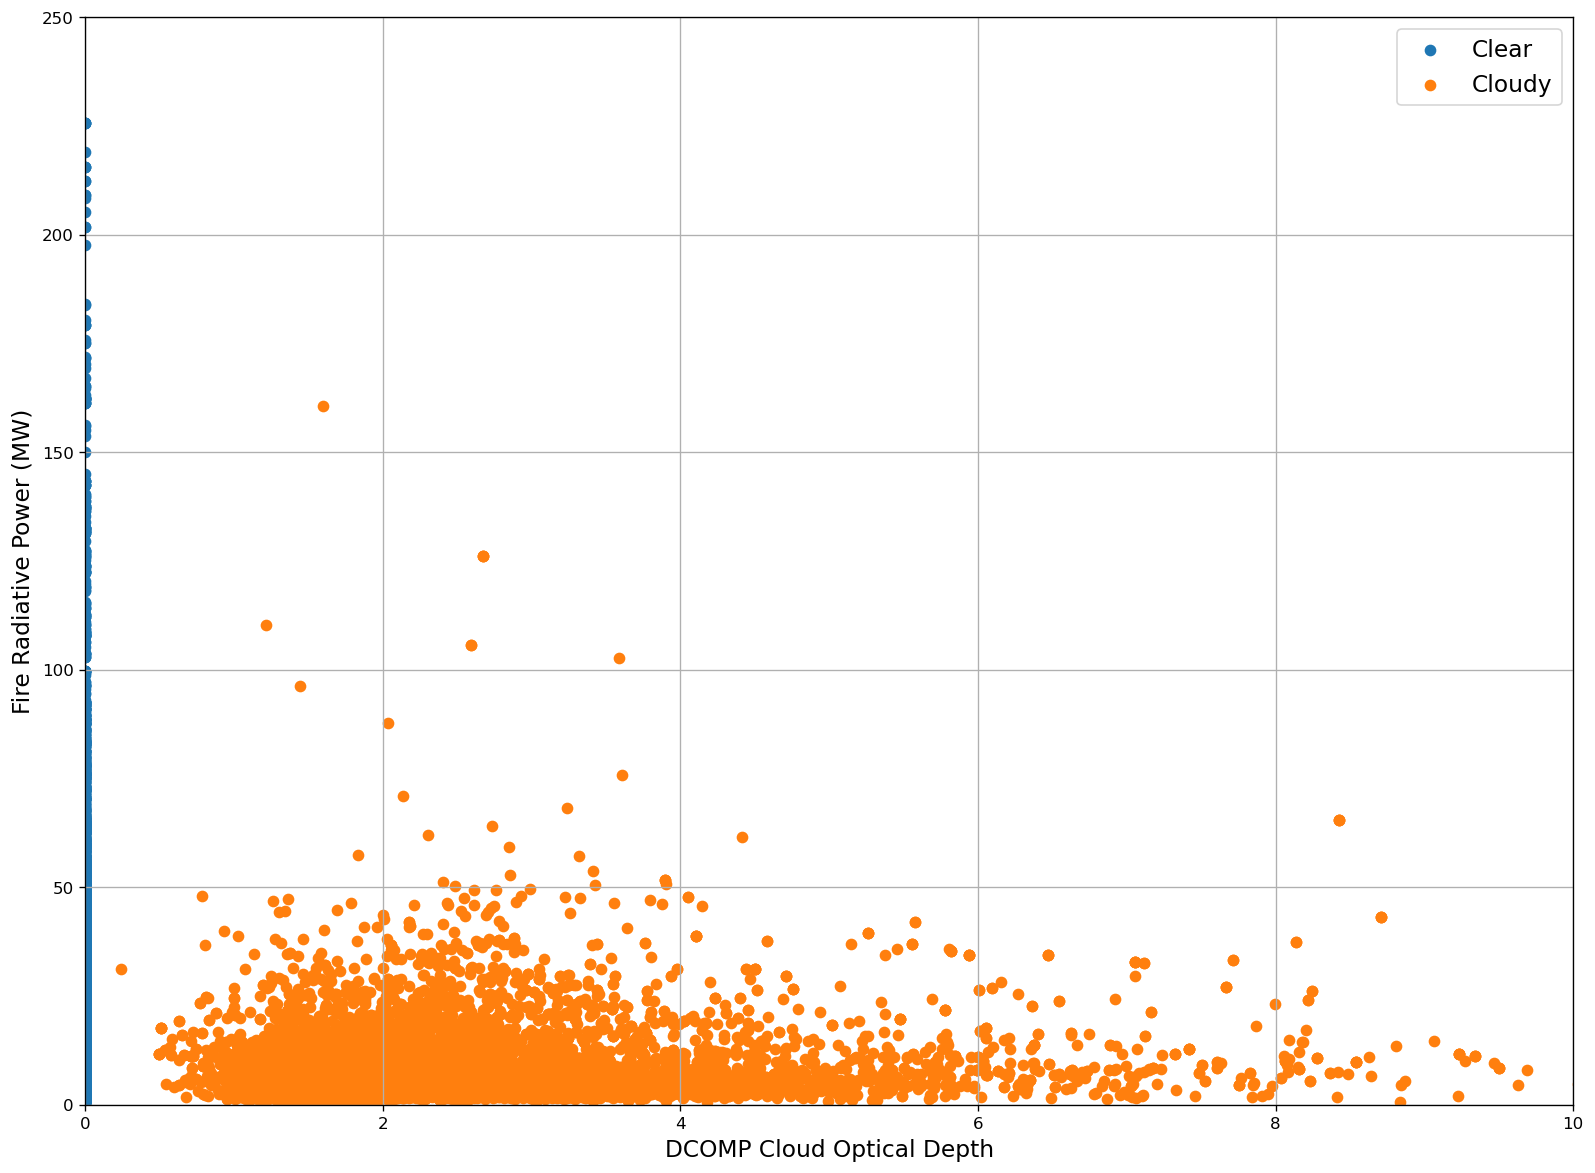

In [87]:
df_cloudy = df[  (df['Day_Night_Flag'] == 'Day') & 
                 (df['CloudMicroVisOD'] > 0.0) & 
                 (df['FP_power'] >= 0.0)      ]

df_clear = df[ (df['Day_Night_Flag'] == 'Day') & 
               (df['Cloud_Mask'] < 2) ]

fig = plt.figure(num=None, figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')


plt.scatter(df_clear['CloudMicroVisOD'].to_numpy(), df_clear['FP_power'].to_numpy(),label='Clear')
plt.scatter(df_cloudy['CloudMicroVisOD'].to_numpy(), df_cloudy['FP_power'].to_numpy(),label='Cloudy')


plt.xlabel("DCOMP Cloud Optical Depth",fontsize=14)
plt.ylabel("Fire Radiative Power (MW)",fontsize=14)

plt.xlim(0,10)
plt.ylim(0,250)

plt.legend(fontsize=14)

plt.grid()

plt.show()

In [35]:
from scipy import stats

import matplotlib.cm as cm

values = df[ ['CloudMicroVisOD','FP_power'] ][  (df['CloudMicroVisOD'] >= 0.0) & (df['FP_power'] >= 0.0)      ].to_numpy()

values

array([[ 0.        , 21.34487724],
       [ 0.        , 10.36973858],
       [ 0.        ,  4.81528044],
       ...,
       [ 0.        ,  1.35622621],
       [ 0.        ,  1.63487446],
       [ 0.        ,  0.91362089]])

In [36]:
values.max()

270.5248107910156

In [37]:
xmin = 0#values.min()
xmax = 5#values.max()
ymin = 0#values.min()
ymax = 20#values.max()

kernel = stats.kde.gaussian_kde(values.T)

In [38]:
print(xmin,xmax)
print(ymin,ymax)

0 5
0 20


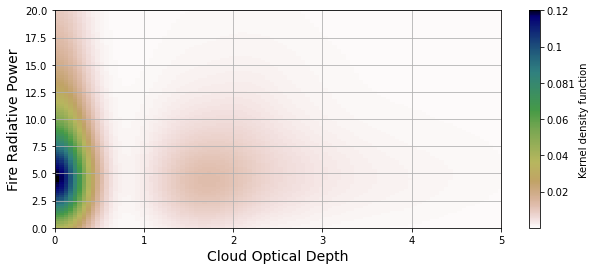

In [39]:

fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.c_[X.ravel(), Y.ravel()]

Z = np.reshape(kernel(positions.T).T, X.T.shape)

cax = ax.imshow(Z.T, interpolation='nearest',
            cmap=cm.gist_earth_r, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto')

#ax.plot([xmin,xmax], [ymin,ymax], 'b--',c='black')

plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xlabel("Cloud Optical Depth")
plt.ylabel("Fire Radiative Power")

plt.grid()

ticks_at = [0, Z.max()/6.0, 2.0*Z.max()/6.0, 3.0*Z.max()/6.0, 4.0*Z.max()/6.0, 5.0*Z.max()/6.0, Z.max()]
cbar = fig.colorbar(cax,ticks=ticks_at,format='%1.2g')
cbar.set_label('Kernel density function')

plt.savefig("FRP_vs_COD.png", bbox_inches='tight',dpi=200, facecolor='white')

plt.show()

In [40]:
tot = df[ ['CloudMicroVisOD','FP_power'] ][  (df['CloudMicroVisOD'] >= 0.0) & (df['FP_power'] >= 0.0) ].shape[0]

c1 = df[ ['CloudMicroVisOD','FP_power'] ][ (df['CloudMicroVisOD'] >= 0.0) & (df['CloudMicroVisOD'] < 5.0) & (df['FP_power'] >= 0.0) ].shape[0]
c2 = df[ ['CloudMicroVisOD','FP_power'] ][ (df['CloudMicroVisOD'] >= 0.0) & (df['CloudMicroVisOD'] >= 5.0) & (df['FP_power'] >= 0.0) ].shape[0]

print( c1 * 100 / tot )
print( c2 * 100 / tot )

98.88869633031497
1.1113036696850223


In [41]:
c2

513

In [42]:
tot

46162

<Figure size 720x720 with 0 Axes>

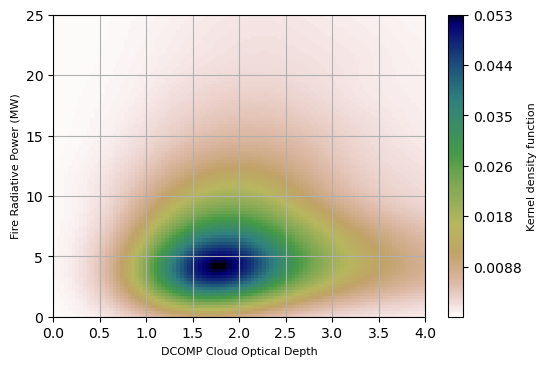

In [170]:
values = df[ ['CloudMicroVisOD','FP_power'] ][  (df['CloudMicroVisOD'] > 0.0) & (df['FP_power'] >= 0.0)      ].to_numpy()

xmin = 0#values.min()
xmax = 4#values.max()
ymin = 0#values.min()
ymax = 25#values.max()

kernel = stats.kde.gaussian_kde(values.T)

fig = plt.figure(figsize=(10,10))

fig = plt.figure(dpi=100)

ax = fig.add_subplot(111)

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.c_[X.ravel(), Y.ravel()]

Z = np.reshape(kernel(positions.T).T, X.T.shape)

cax = ax.imshow(Z.T, interpolation='nearest',
            cmap=cm.gist_earth_r, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto')

#ax.plot([xmin,xmax], [ymin,ymax], 'b--',c='black')

plt.xlabel('x',fontsize=8)
plt.ylabel('y',fontsize=8)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xlabel("DCOMP Cloud Optical Depth",fontsize=8)
plt.ylabel("Fire Radiative Power (MW)",fontsize=8)

plt.grid()

ticks_at = [0, Z.max()/6.0, 2.0*Z.max()/6.0, 3.0*Z.max()/6.0, 4.0*Z.max()/6.0, 5.0*Z.max()/6.0, Z.max()]
cbar = fig.colorbar(cax,ticks=ticks_at,format='%1.2g')
cbar.set_label('Kernel density function',fontsize=8)

#plt.savefig("FRP_vs_COD_02.png", bbox_inches='tight',dpi=100, facecolor='white')

plt.show()

<AxesSubplot:>

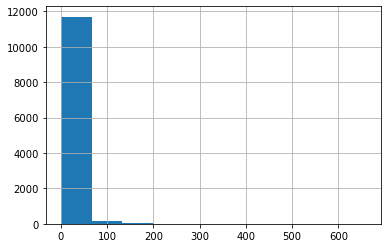

In [44]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].hist()

<AxesSubplot:>

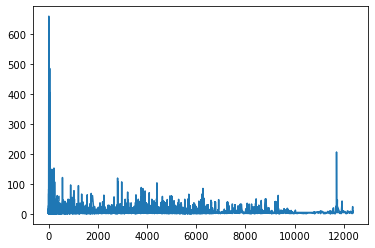

In [45]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] == 3) ]['FP_power'].plot()

In [46]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) &
  (df['FP_power'] > 300)     ]['FP_power']

8       659.042969
12      659.042969
13      659.042969
30      485.331757
31      485.331757
36      405.029602
42      485.331757
45      485.331757
46      405.029602
8971    316.943939
Name: FP_power, dtype: float32

In [47]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].max()

659.04296875

In [48]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] > 1) ]['FP_power'].mean()

11.620408058166504

In [49]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] == 3) ]['FP_power'].mean()

11.020554542541504

In [50]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['Cloud_Mask'] == 0) ]['FP_power'].mean()

9.678166389465332

<AxesSubplot:>

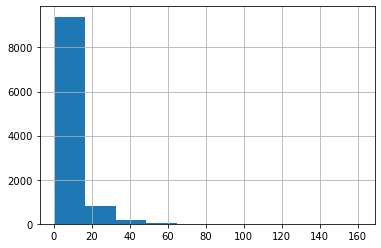

In [51]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['CloudMicroVisOD'] > 0) ]['FP_power'].hist()

In [52]:
df[ (df['Day_Night_Flag'] == 'Day') & 
    (df['CloudMicroVisOD'] > 0) ]['FP_power'].mean()

8.139678001403809

In [53]:
df[ ['CloudMicroVisOD','FP_power'] ][  (df['CloudMicroVisOD'] > 0.0) & (df['FP_power'] >= 0.0)      ].mean()

CloudMicroVisOD    2.44479
FP_power           8.13415
dtype: float64

In [54]:
df[ ['CloudMicroVisOD','FP_power'] ][  (df['CloudMicroVisOD'] == 0.0) & (df['FP_power'] >= 0.0)      ].mean()

CloudMicroVisOD    0.000000
FP_power           9.950916
dtype: float64